<a href="https://colab.research.google.com/github/mr-awesome-1/hacker-earth-auto-tag/blob/master/he_autotag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Mon May 25 20:01:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
!git clone https://github.com/mr-awesome-1/hacker-earth-auto-tag.git
!unzip -qq /content/hacker-earth-auto-tag/autotag.zip

Cloning into 'hacker-earth-auto-tag'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 1), reused 10 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [0]:
class CustomData(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        path = self.X[i]
        data = Image.open("dataset/Train Images/"+path)
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

In [0]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]

In [0]:
transform = transforms.Compose([
    transforms.Resize((80,80)),
    #  transforms.CenterCrop((32, 32)),
    #  transforms.RandomCrop((50, 50)),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=(-30, 30)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

data_dir = "dataset/Train Images"
classes = ['Food', 'Attire', 'Decorationandsignage', 'misc']
class_map = {'Food':0, 'Attire':1, 'Decorationandsignage':2, 'misc':3}

df = pd.read_csv("dataset/train.csv").replace({'Class':class_map})
rem = []
for i, n in df.iterrows():
    image = Image.open("dataset/Train Images/"+n['Image'])
    if image.mode == 'L' or image.mode != 'RGB':
        rem.append(n['Image'])
df = df[~df.Image.isin(rem)]

In [0]:
split = np.random.rand(len(df)) < 0.8
train = df[split]
test = df[~split]

train_images = train.iloc[:,0].to_numpy()
train_labels = train.iloc[:,1].to_numpy()
test_images = test.iloc[:,0].to_numpy()
test_labels = test.iloc[:,1].to_numpy()

In [0]:
class_sample_counts = df.groupby(['Class']).count().to_numpy()
weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
weights[3] += 0.0004
train_weights = weights[train_labels].squeeze()
test_weights = weights[test_labels].squeeze()

In [0]:
train_data = CustomData(train_images, train_labels, transform)
test_data = CustomData(test_images, test_labels, transform)

batch_size = 32
# dataloaders
train_loader = DataLoader(train_data, sampler=WeightedRandomSampler(train_weights, len(train_weights), replacement=True), batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, sampler=WeightedRandomSampler(test_weights, len(test_weights), replacement=True), batch_size=batch_size, drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

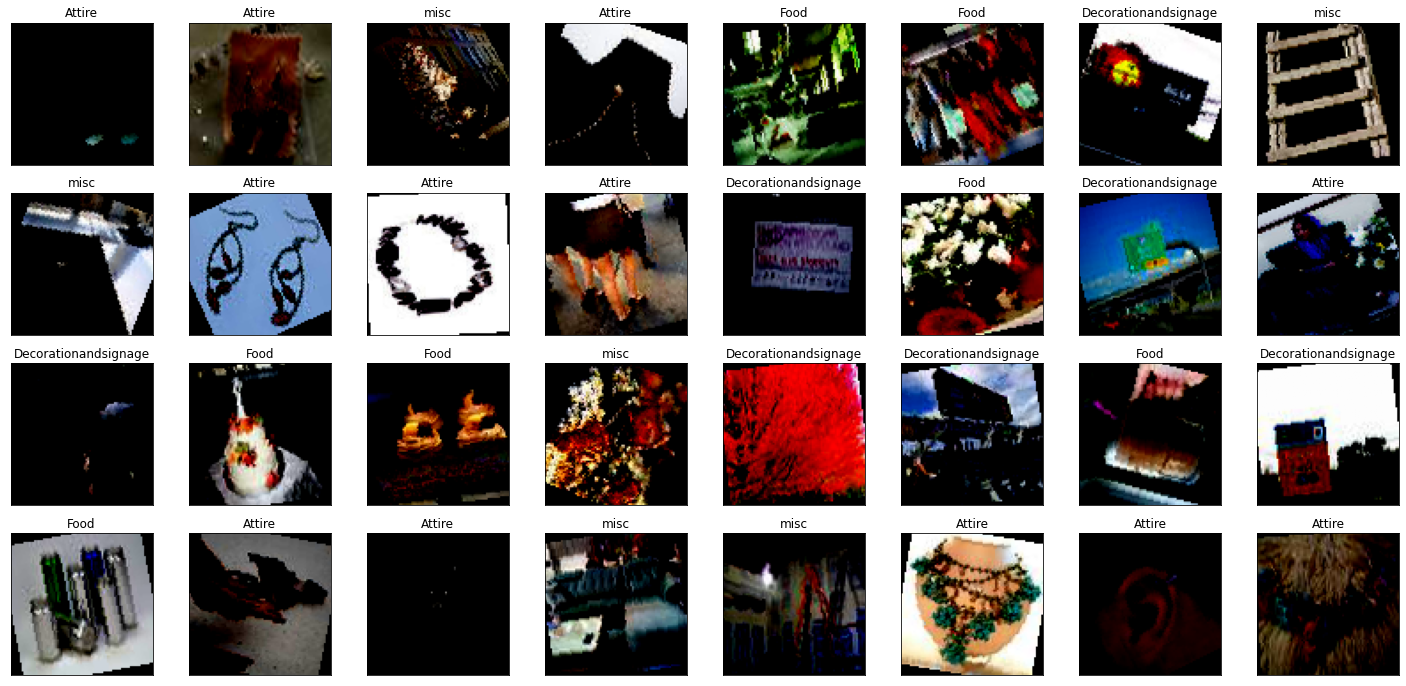

In [0]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# images = np.array(images, dtype=np.float32)
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 12))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [0]:
net = torchvision.models.resnext101_32x8d(pretrained=True, progress=True).to(device)
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [0]:
import torch.nn as nn

# n_inputs = net.classifier[6].in_features
n_inputs = net.fc.in_features

last_layer = nn.Linear(n_inputs, len(classes))

net.fc = last_layer

net.to(device)

# check to see that your last layer produces the expected number of outputs
# print(net.classifier[6].out_features)
# # print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [0]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
# optimizer = optim.Adam(net.classifier.parameters(), lr=0.0001)
optimizer = optim.Adam(net.parameters(), lr=0.000001)

In [0]:
# number of epochs to train the model
n_epochs = 100

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    train_loss_ep = 0.0
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        train_loss_ep += loss.item()
        
        if batch_i % 200 == 199:    # print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 200))
            train_loss = 0.0
    print('Epoch %d loss: %.16f' %(epoch, train_loss / len(train_loader)))

Epoch 1, Batch 200 loss: 1.3858904337882996
Epoch 1, Batch 400 loss: 1.4386399406194688
Epoch 1, Batch 600 loss: 1.4129205149412156
Epoch 1, Batch 800 loss: 1.3599127280712127
Epoch 1, Batch 1000 loss: 1.3685996347665788
Epoch 1, Batch 1200 loss: 1.3677708566188813
Epoch 1, Batch 1400 loss: 1.3788678508996963
Epoch 1, Batch 1600 loss: 1.3804671519994736
Epoch 1, Batch 1800 loss: 1.3921808218955993
Epoch 1, Batch 2000 loss: 1.3426772761344909
Epoch 1, Batch 2200 loss: 1.3738501501083373
Epoch 1, Batch 2400 loss: 1.3383705884218215
Epoch 1, Batch 2600 loss: 1.3472566434741020
Epoch 1, Batch 2800 loss: 1.3911226010322570


KeyboardInterrupt: ignored

In [0]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

net.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = net(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(4):
        label = target.data
        class_correct[label] += correct.item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.922246

Test Accuracy of  Food: 88% (804/904)
Test Accuracy of Attire: 83% (860/1024)
Test Accuracy of Decorationandsignage: 81% (996/1216)
Test Accuracy of  misc: 62% (932/1488)

Test Accuracy (Overall): 77% (3592/4632)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

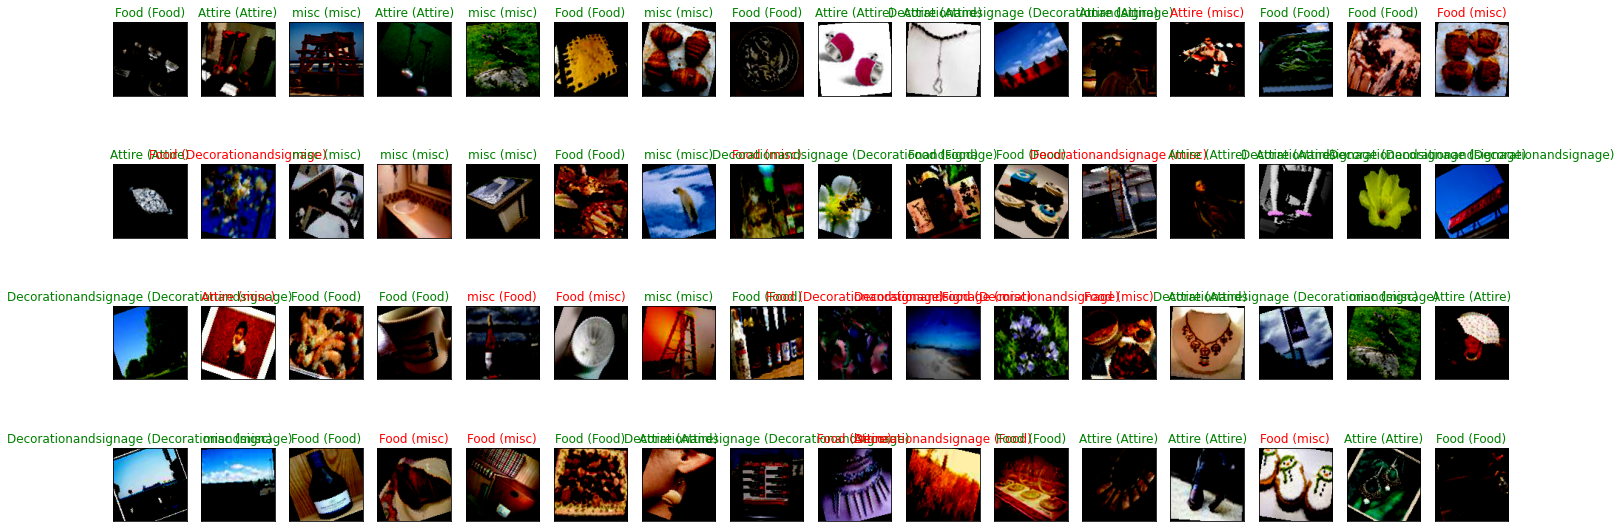

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
images = images.to(device)

# get sample outputs
output = net(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu(), (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))